### Predictions
I've adopted models from HW1. I rescaled data with standard scaler. Below estimated probabilities that two observations (1742 and 601) from test dataset are from class 0. Observation 601 is misclassified by all methods. Probabilities for random forest and knn have low precision as 100 trees and 5 neightbours respectively have been used.

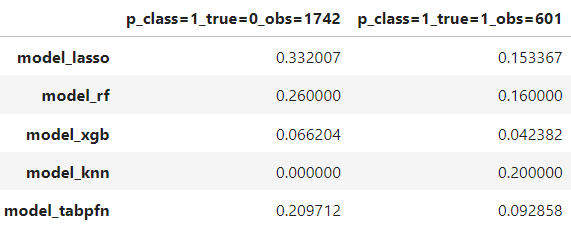

### Stability across same model and observation
Below 4 runs for lime explainer for random forest, changing order of variables is clearly visible, from my expirience I can say that I believe that **variable importance** based on permutations of variables would give more stable results between different training runs of random forest

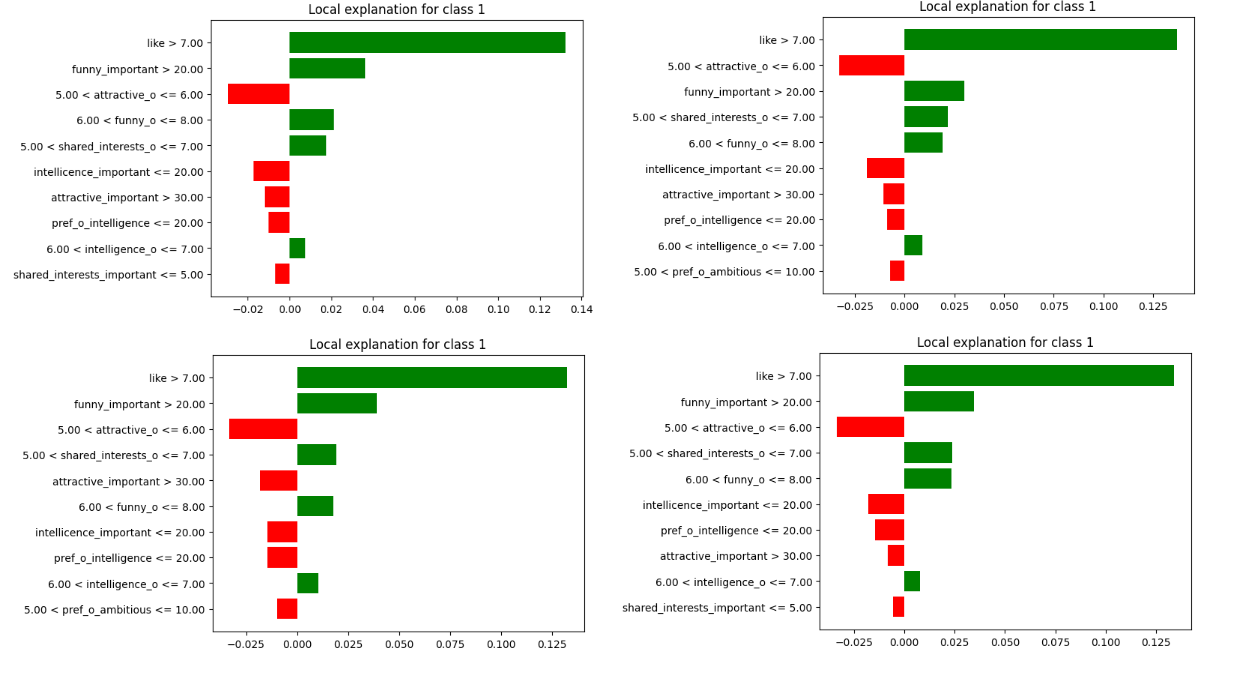

### Many models, two observetions, some loose insights
I guess that more global models have more stable explanations between variables - from all models below lasso is most global one as it assumes *maginal effects* (marginal derivatives of response over dataset variables) to have the same functional form over whole data space.
And its explanation for both observations are pretty similar (in comparison of pairs of explanations for other models). 
**knn** and **random forest** have some deep connetions, and their explanations changes in similar way. **xgboost** is again mode global, as constructed trees are not independent. 

* For **lasso model** differences between explanation of two choosen observations are high - 'like' variable drops from first to sixth place but at least signs of effects seems to be consistent.
* In case of **random forest** there is major flip - from a few dominanting positive effects for obs 1742, to dominating negative effects for second observation.
* For **xgboost** sign of effect of *like* variables also flims between both observations also order of variables changes
* For **knn-5** explanation flips from 3 negative and 7 positive into 3 positive and 7 negative.
* **tabPFN** seems to be more stable, but again signs of largest effects flips.
  
*It was hard to manage plots generated by lime and dalex, so below plots are custom creatred

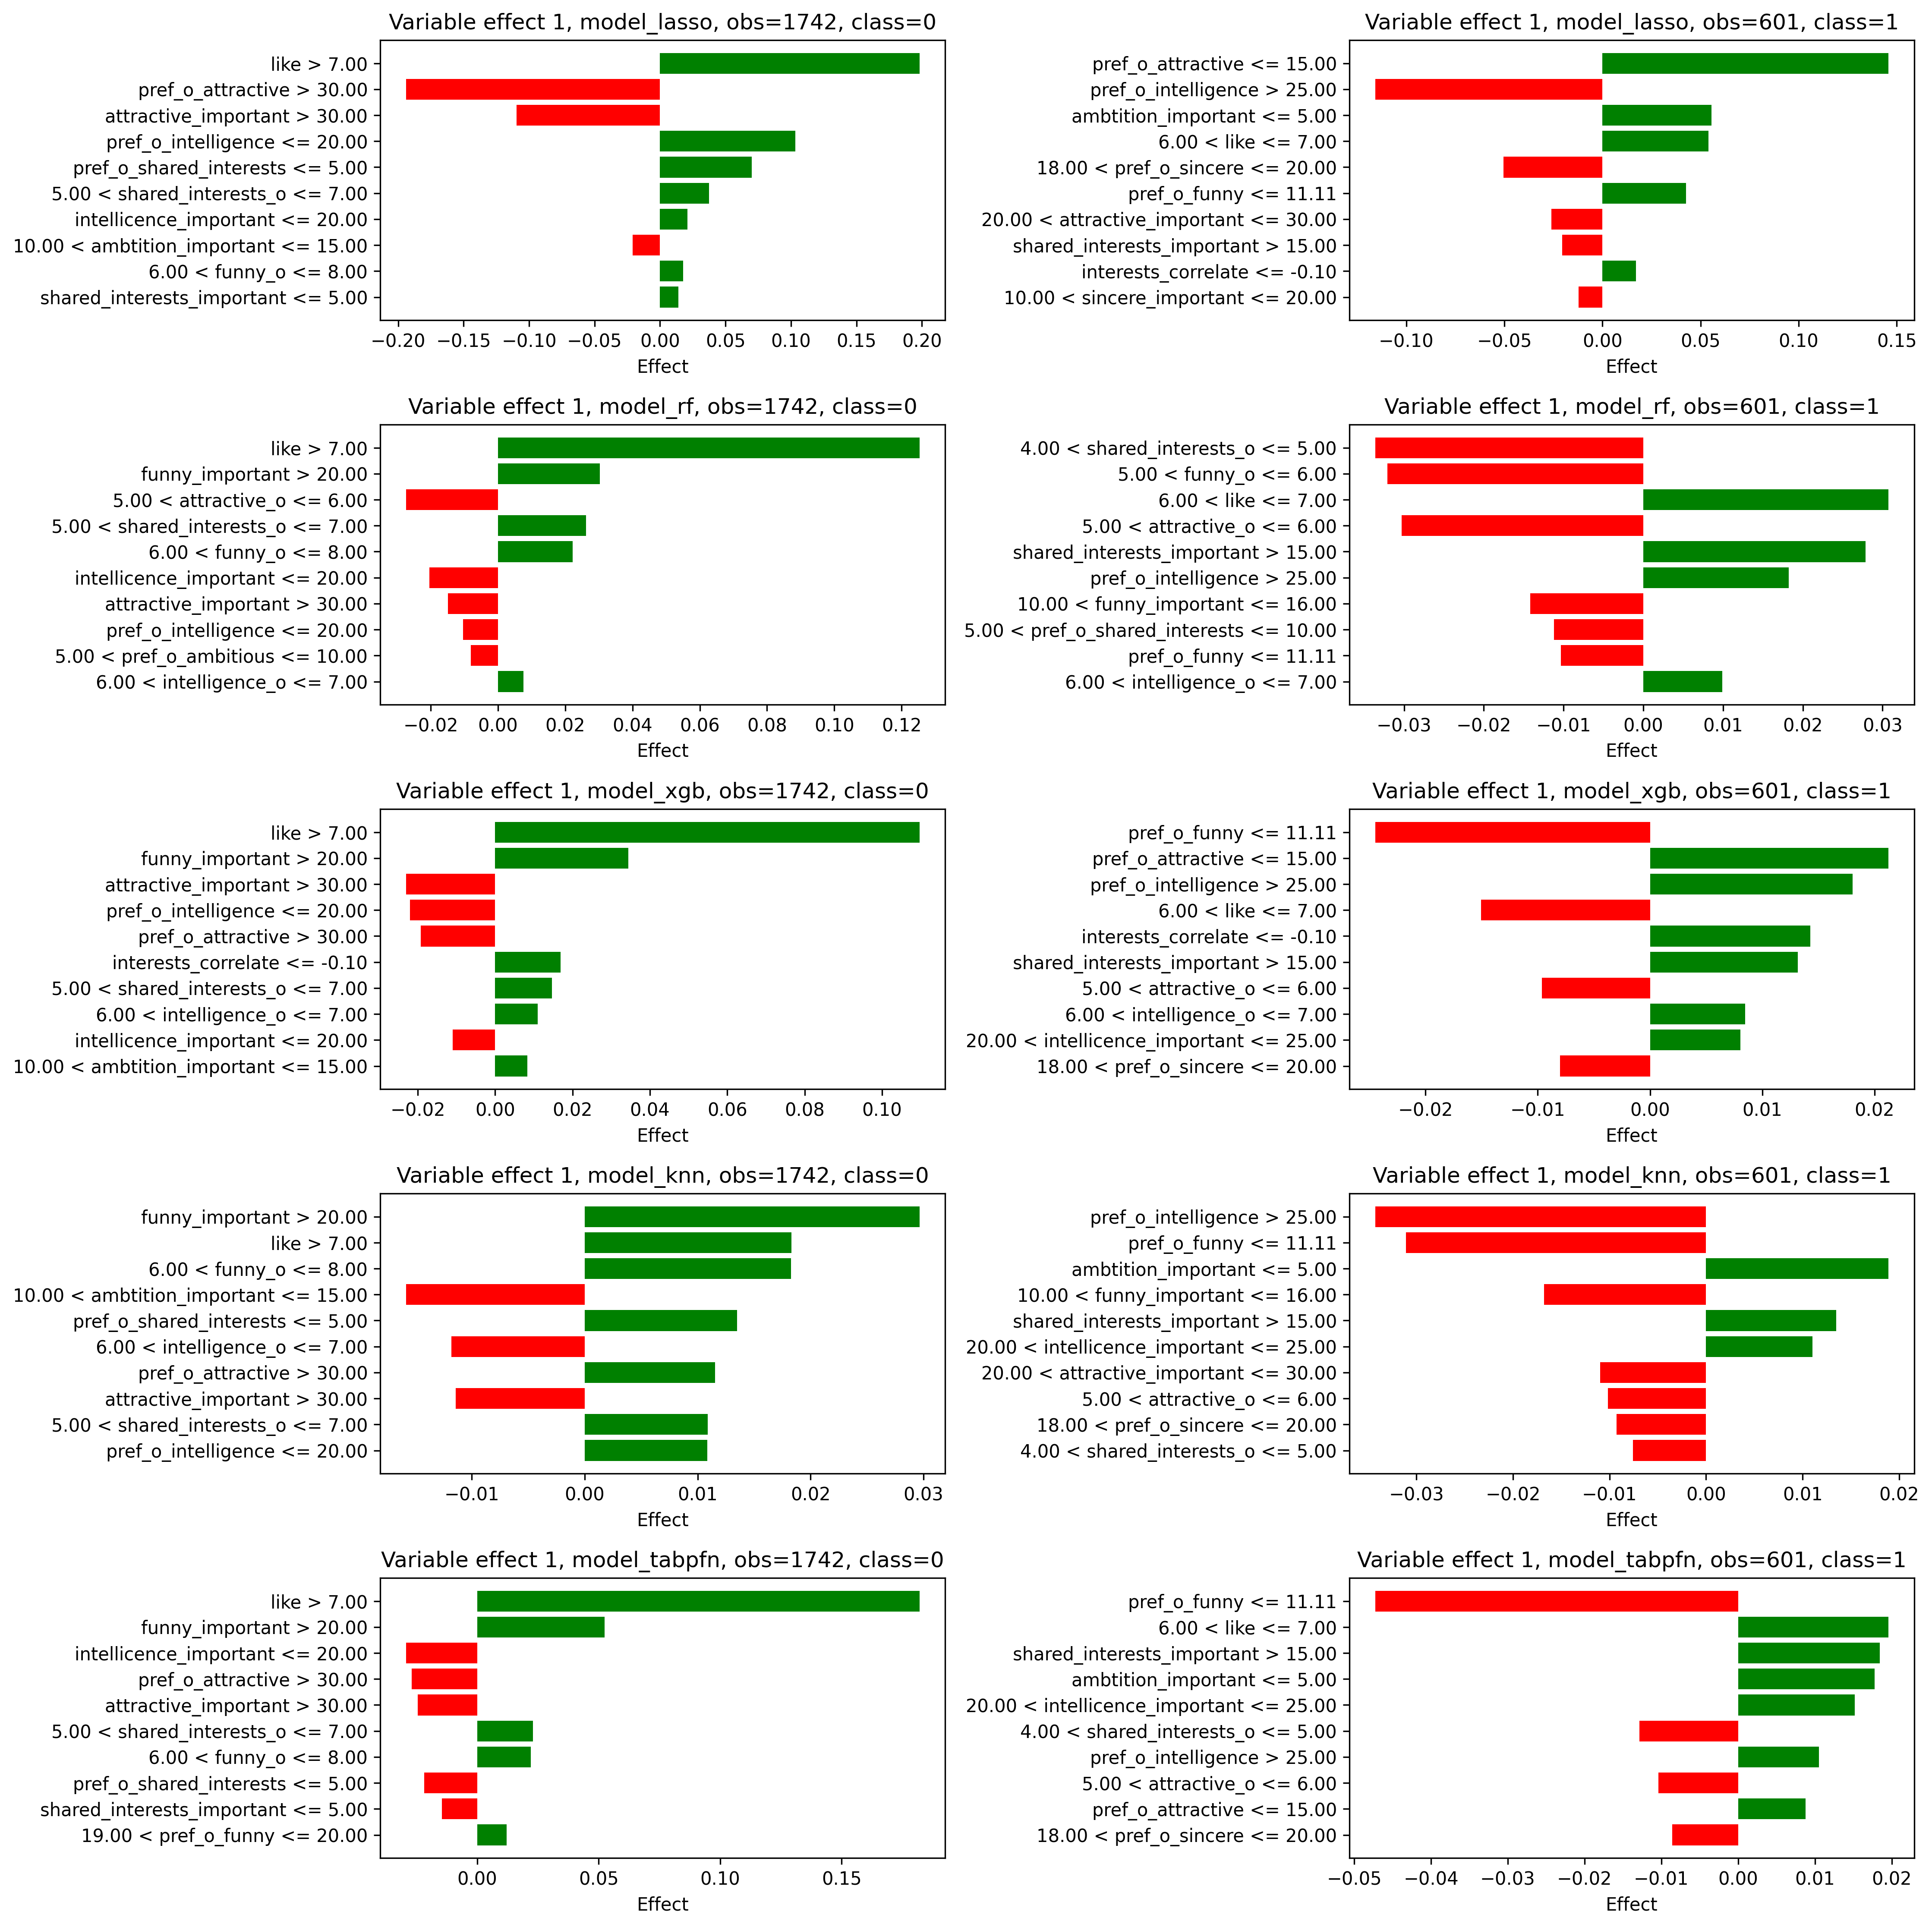

# Appendix

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [228]:
# !pip install -q tabpfn

# jupyter nbconvert --to=html --template=classic *.ipynb --no-input --output=HW1.html

In [229]:
import numpy as np
import pandas as pd
from os.path import exists

repo_url = "https://raw.githubusercontent.com/adrianstando/imbalanced-benchmarking-set/main/datasets/"
dataset = "SpeedDating.csv" # ♥


if exists(dataset):
    # print("File already exists, loading file")
    df = pd.read_csv(dataset, index_col=0)
else:
    try:
        df = pd.read_csv(repo_url + dataset, index_col=0)
        df.to_csv(dataset)
    except:
        print("somthing is not yes")

### SpeedDating

### Simple EDA

Densities of variables in both TARGET classes - empirical distributions are similar

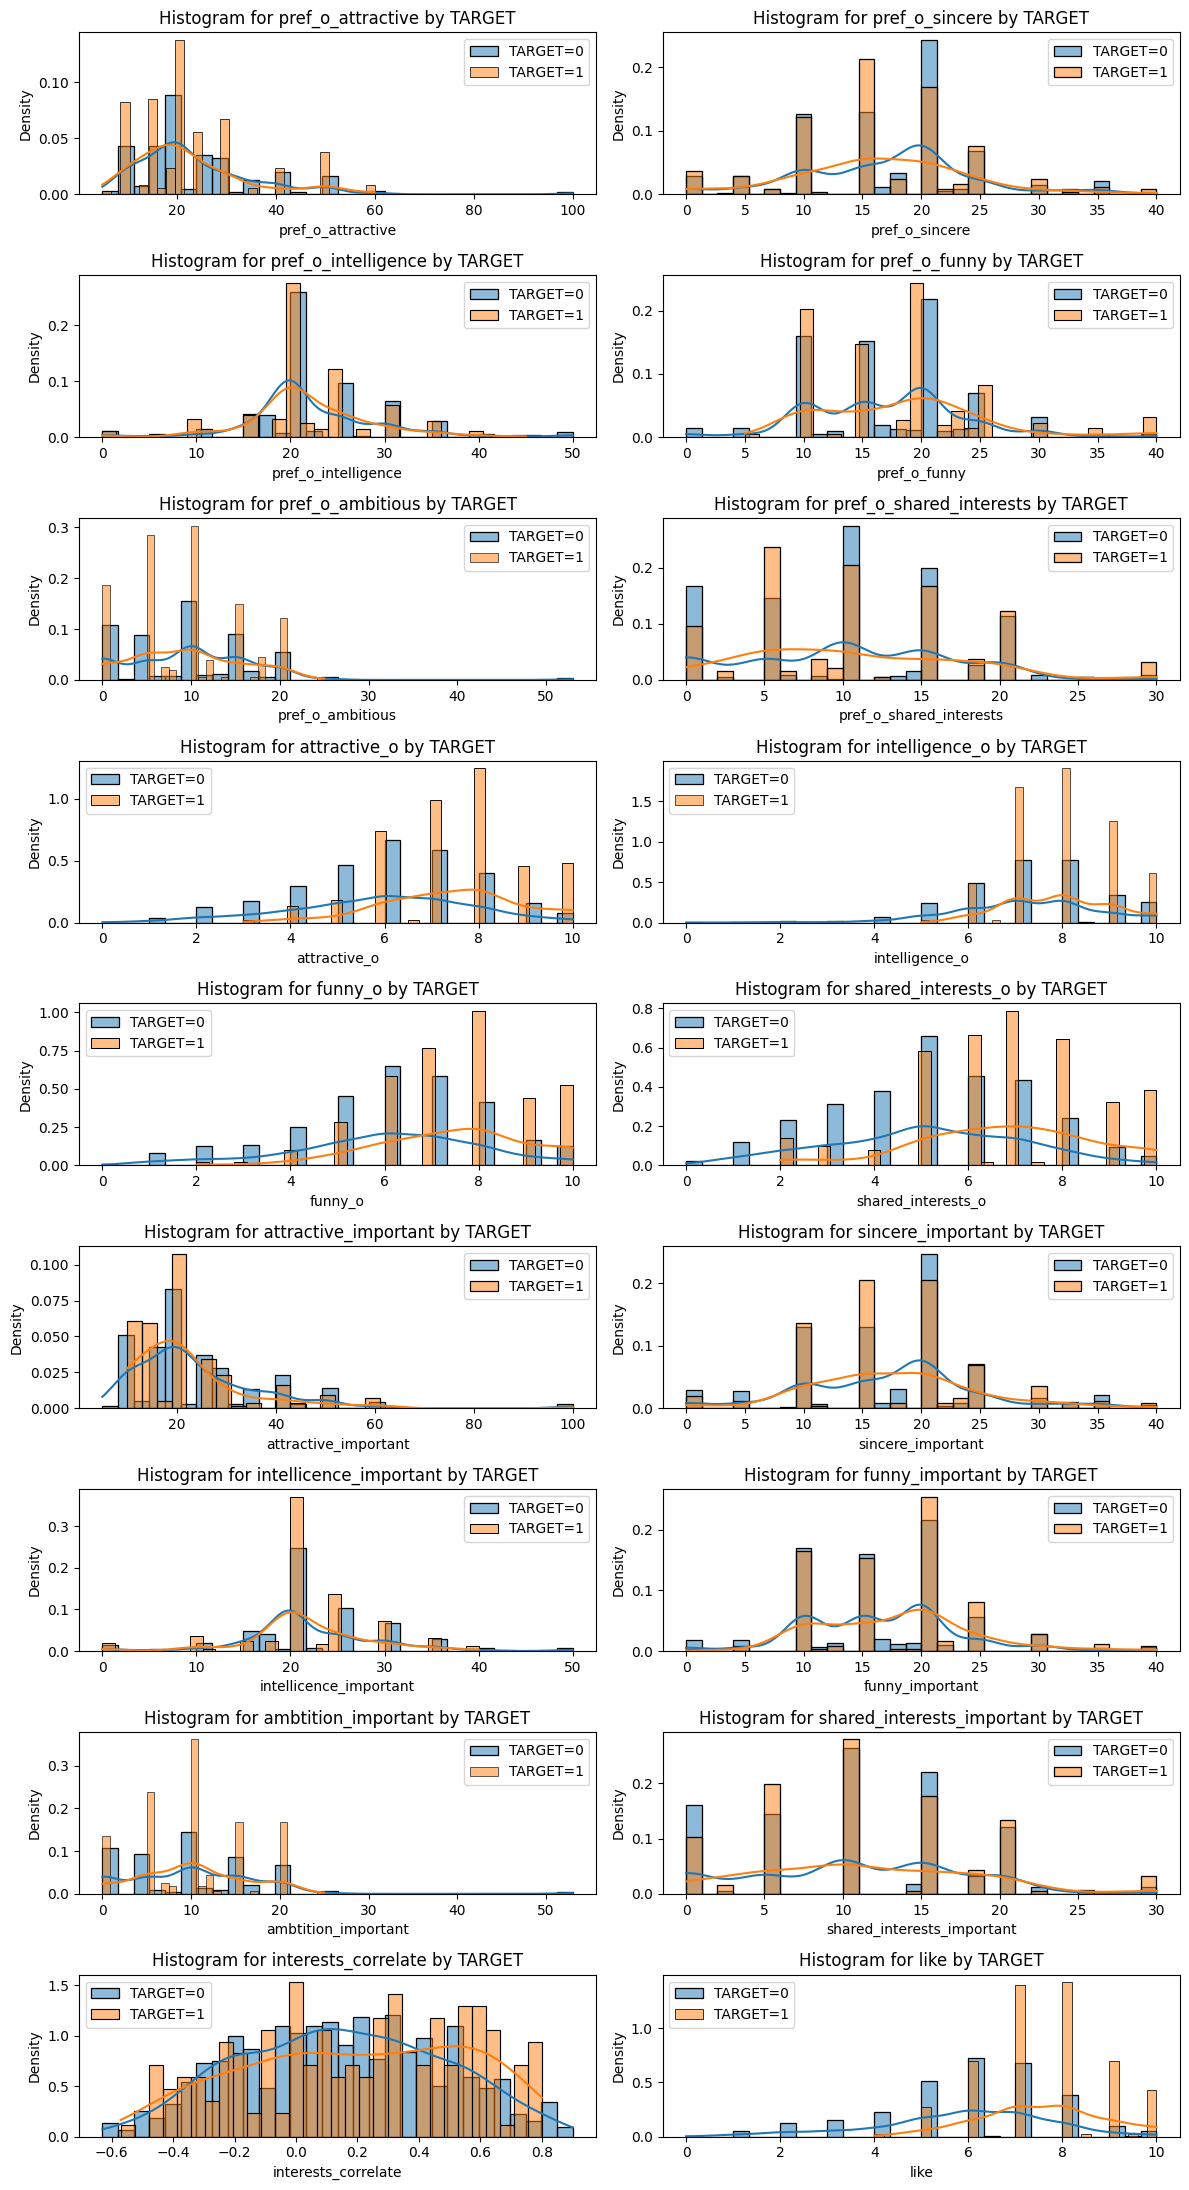

In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(9, 2, figsize=(12, 22))

axes = axes.ravel()

for i, col in enumerate(df.columns):
    if col != "TARGET":
        sns.histplot(df[df['TARGET'] == 0][col], bins=30, label='TARGET=0', stat='density', kde=True, ax=axes[i])
        sns.histplot(df[df['TARGET'] == 1][col], bins=30, label='TARGET=1', stat='density', kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram for {col} by TARGET')
        axes[i].legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()        

In [231]:
# I use 5 quite different models "rf", "xgb", "lasso",  "knn", "tabpfn"

In [232]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

np.random.seed(42)

y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Choose your test size to split between training and testing sets:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

models = {}

In [233]:
from sklearn.linear_model import LogisticRegression

lasso_logistic = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
models["model_lasso"] = lasso_logistic.fit(X, y)

In [234]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=12)
models["model_rf"] = rf.fit(X, y)

In [235]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,  
    # early_stopping_rounds=3 # can't use directly in CV setting with train-test split only (val dataset would be needed)
    # scale_pos_weight=df.TARGET.mean()  # using 'scale_pos_weight' this way would be data leakage
)

models["model_xgb"] = xgb_clf.fit(X, y)

In [236]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
models["model_knn"] = knn.fit(X, y)

In [287]:
from tabpfn import TabPFNClassifier

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=10)
models["model_tabpfn"] = tabpfn.fit(X, y)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [238]:
models.keys()

dict_keys(['model_lasso', 'model_rf', 'model_xgb', 'model_knn', 'model_tabpfn'])

#### 1. Calculate the predictions for some selected observations

In [239]:
y_class_0 = y_test[y_test==0].index[0]
y_class_1 = y_test[y_test==1].index[0]

obs = X_test.loc[[y_class_0, y_class_1]]
obs

,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,intelligence_o,funny_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,interests_correlate,like
1742,40.0,15.0,10.0,20.0,10.0,5.0,6.0,7.0,7.0,7.0,35.0,15.0,5.0,30.0,15.0,0.0,-0.15,9.0
601,10.0,20.0,40.0,10.0,10.0,10.0,6.0,7.0,6.0,5.0,25.0,15.0,25.0,15.0,0.0,20.0,-0.10,7.0


In [273]:
y_test.loc[[y_class_0, y_class_1]]

1742    0
601     1
Name: TARGET, dtype: int64

In [331]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

results = {}
for name, model in models.items():
    pred = model.predict_proba(obs)
    print(name, "\n", pred)
    results[name] = list(pred[:,1])

model_lasso 
 [[0.66799307 0.33200693]
 [0.84663306 0.15336694]]
model_rf 
 [[0.74 0.26]
 [0.84 0.16]]
model_xgb 
 [[0.93379563 0.06620435]
 [0.9576179  0.04238215]]
model_knn 
 [[1.  0. ]
 [0.8 0.2]]


C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


model_tabpfn 
 [[0.790288   0.20971204]
 [0.9071422  0.09285779]]


In [332]:
results

{'model_lasso': [0.3320069286648734, 0.1533669438853311],
 'model_rf': [0.26, 0.16],
 'model_xgb': [0.06620435, 0.04238215],
 'model_knn': [0.0, 0.2],
 'model_tabpfn': [0.20971204, 0.092857786]}

In [303]:
# y_test.loc[i]
# [i for i in obs.index]

[1742, 601]

In [333]:
result = pd.DataFrame(results).T
result.columns = [f"p_class=1_true={y_test.loc[i]}_obs={i}" for i in obs.index]
result

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,p_class=1_true=0_obs=1742,p_class=1_true=1_obs=601
model_lasso,0.332007,0.153367
model_rf,0.260000,0.160000
model_xgb,0.066204,0.042382
model_knn,0.000000,0.200000
model_tabpfn,0.209712,0.092858


#### Q2: Then, calculate the decomposition of these predictions with LIME using the package of choice, e.g. in Python: lime, dalex, in R: iml, localModel.i

In [386]:
import dalex as dx

explainers = {}
for name, model in models.items():
    explainers[name] = dx.Explainer(model, X, y, verbose=False, label=name) 

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the

In [441]:
explainers

{'model_lasso': <dalex._explainer.object.Explainer at 0x27851a8fcd0>,
 'model_rf': <dalex._explainer.object.Explainer at 0x278565924d0>,
 'model_xgb': <dalex._explainer.object.Explainer at 0x278564c7390>,
 'model_knn': <dalex._explainer.object.Explainer at 0x2784f6a9490>,
 'model_tabpfn': <dalex._explainer.object.Explainer at 0x2785669e6d0>}

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\torch\utils

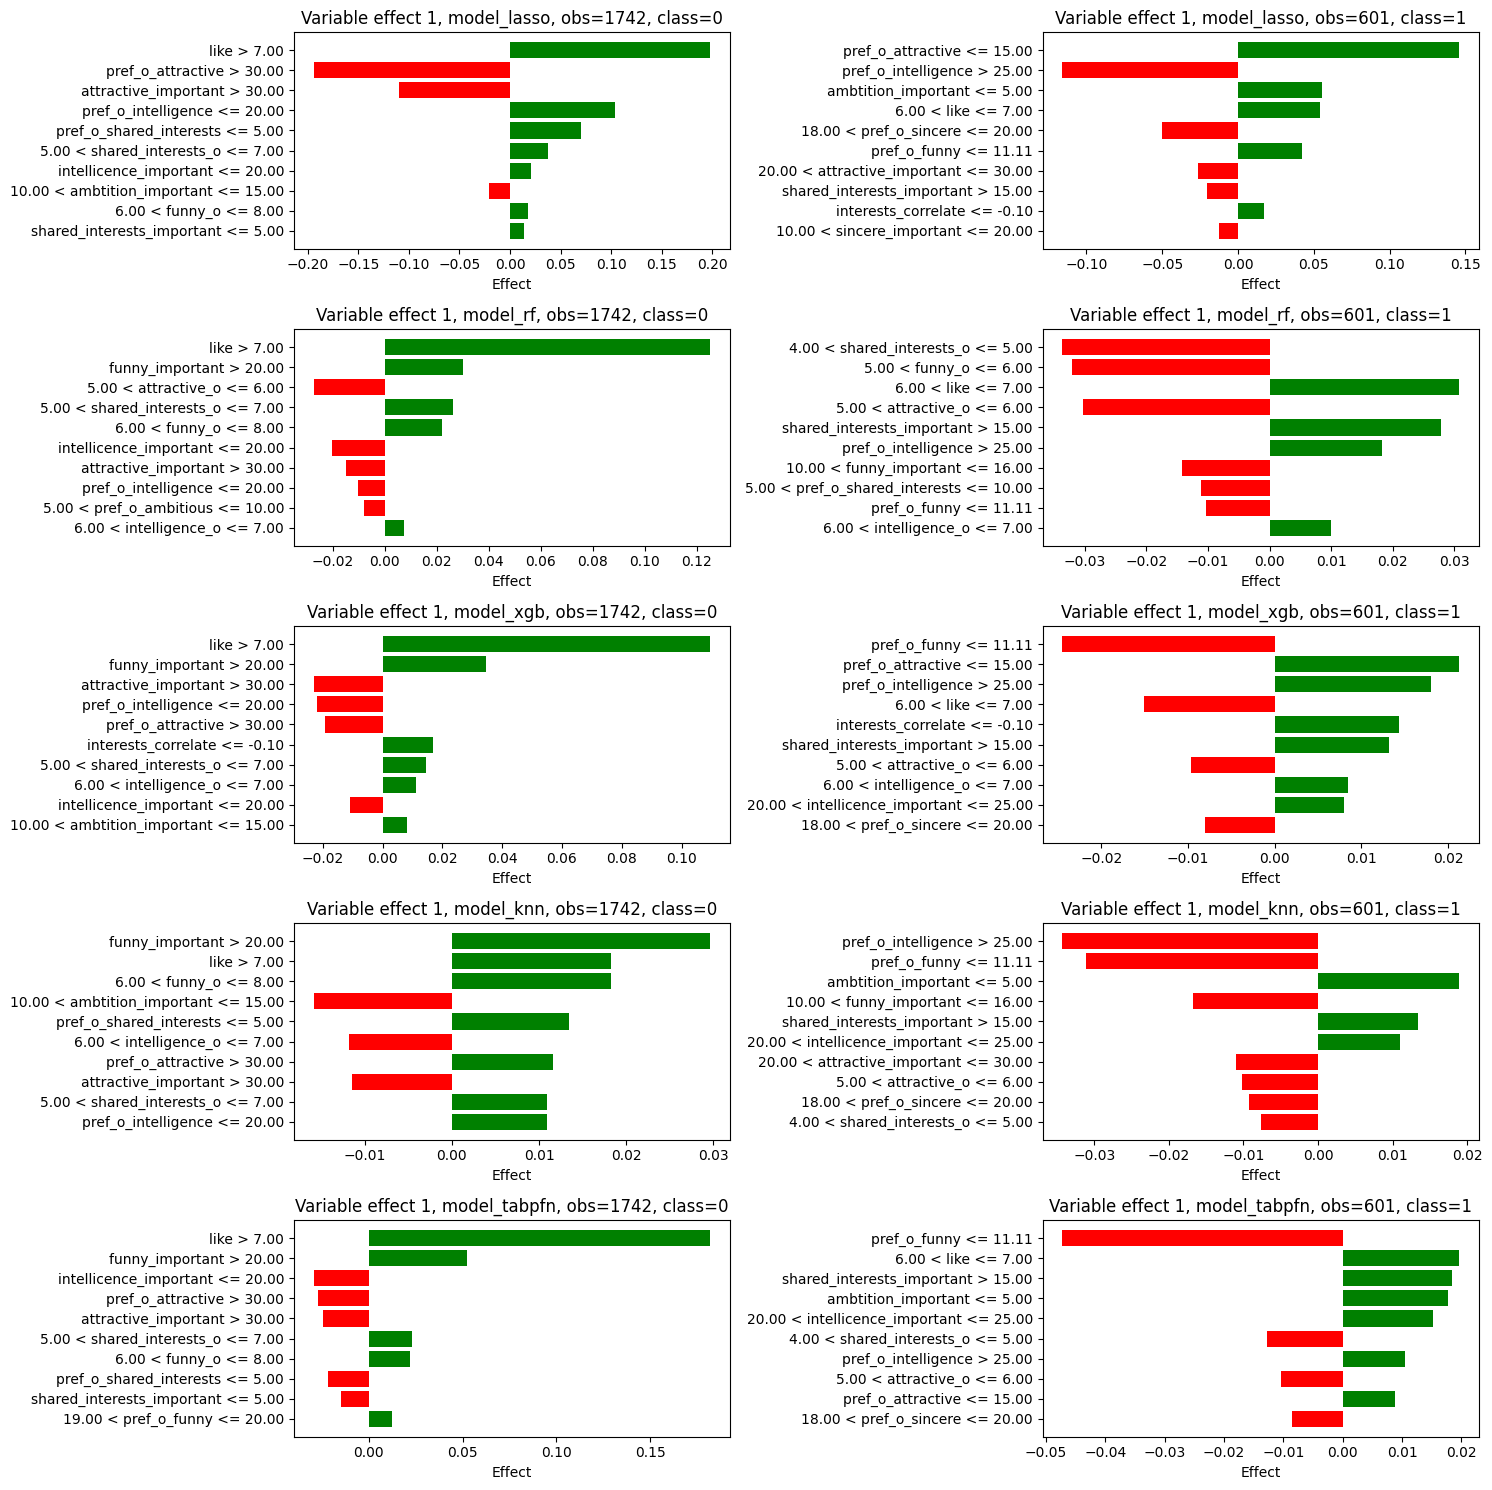

In [486]:
import matplotlib.pyplot as plt

def plot_subplot(ax, explanation, title):
    variables = explanation.result["variable"]
    effects = explanation.result["effect"]
    
    colors = ['green' if effect > 0 else 'red' for effect in effects]
    
    ax.barh(variables, effects, color=colors)
    ax.set_xlabel('Effect')
    ax.set_title(title)
    ax.invert_yaxis()

fig, axes = plt.subplots(5, 2, figsize=(15, 15))

for i, ax in enumerate(axes.ravel()):
    
    model_name, exaplainer = list(explainers.items())[i // 2]  # only 5 models, but 10 plots so we cant zip them
    explainer = explainers[model_name]

    binary = i % 2
    if binary == 0:    
        explanation = explainer.predict_surrogate(obs.loc[y_class_0])
    else:
        explanation = explainer.predict_surrogate(obs.loc[y_class_1])

    title = f"Variable effect 1, {model_name}, obs={[y_class_0, y_class_1][binary]}, class={binary}"
    plot_subplot(ax, explanation, title=title)
    
plt.tight_layout()
plt.savefig("all_effects.png", dpi=300, bbox_inches="tight")
plt.show()

MODEL_RF


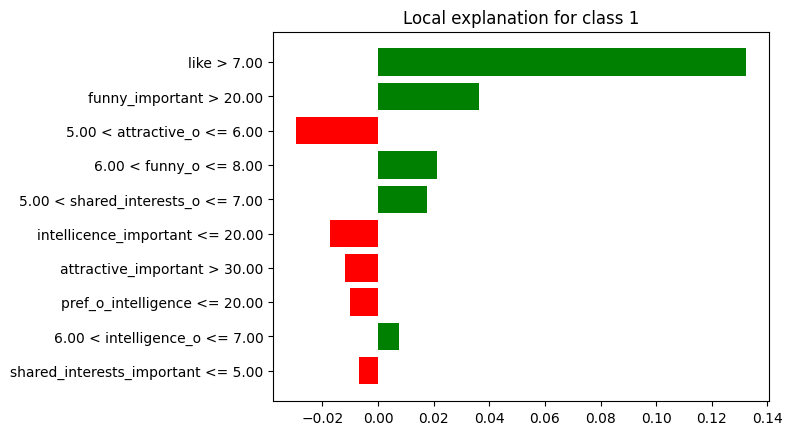

In [504]:
name = "model_rf"
np.random.seed(123)
print(name.upper())
explainer = explainers[name]
explanation = explainer.predict_surrogate(obs.loc[y_class_0])
explanation.plot(return_figure=False)

MODEL_RF


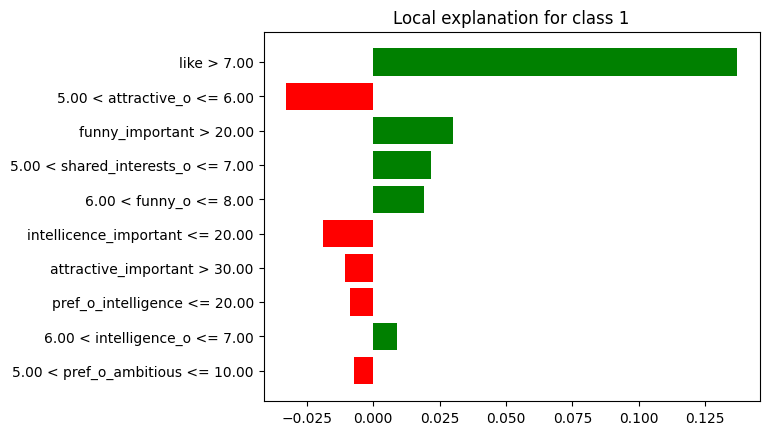

In [503]:
name = "model_rf"
np.random.seed(123+1)
print(name.upper())
explainer = explainers[name]
explanation = explainer.predict_surrogate(obs.loc[y_class_0])
explanation.plot(return_figure=False)

MODEL_RF


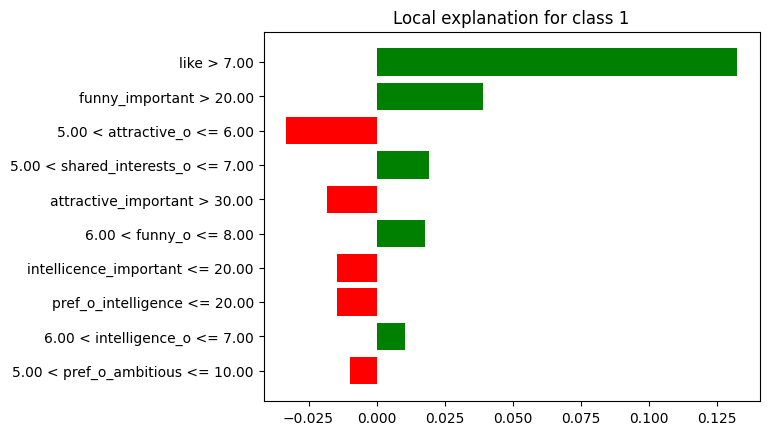

In [502]:
name = "model_rf"
np.random.seed(123+2)
print(name.upper())
explainer = explainers[name]
explanation = explainer.predict_surrogate(obs.loc[y_class_0])
explanation.plot(return_figure=False)

MODEL_RF


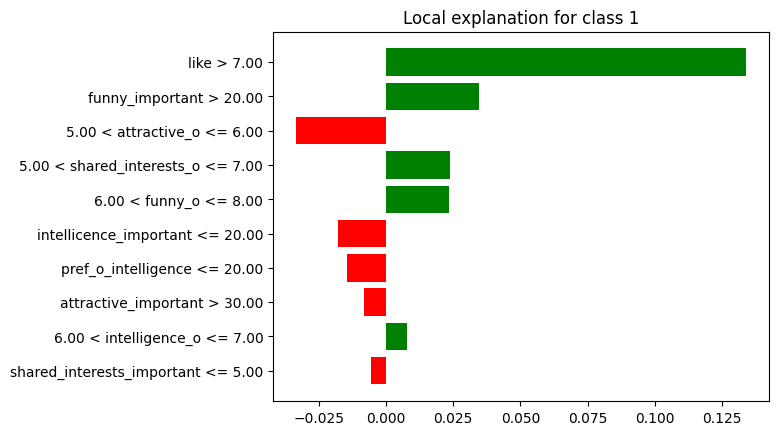

In [501]:
name = "model_rf"
np.random.seed(123+3)
print(name.upper())
explainer = explainers[name]
explanation = explainer.predict_surrogate(obs.loc[y_class_0])
explanation.plot(return_figure=False)

MODEL_LASSO


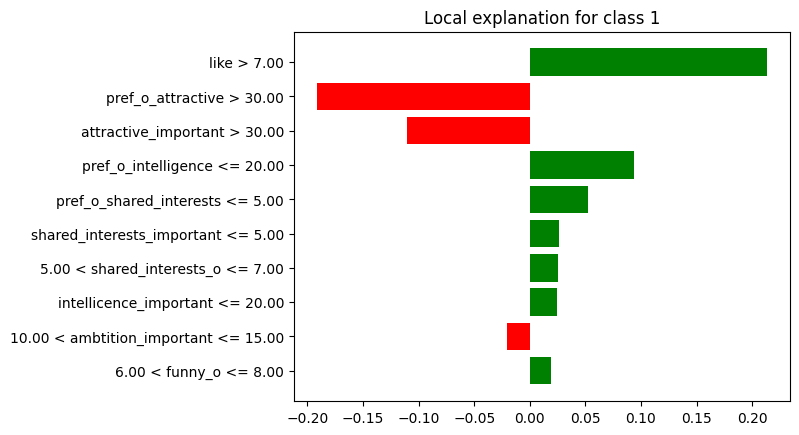

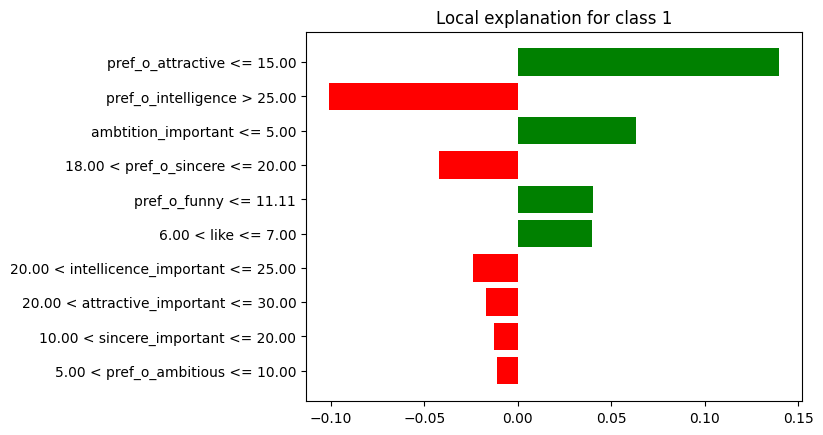

In [442]:
name = "model_lasso"
print(name.upper())
explainer = explainers[name]
explanation = explainer.predict_surrogate(obs.loc[y_class_0])
explanation.plot(return_figure=False)
explanation = explainer.predict_surrogate(obs.loc[y_class_1])
explanation.plot(return_figure=False)

In [434]:
# pd.concat([
#     explainer.model_performance().result,
#     explainer_xgb_optuna.model_performance().result,
#     explainer_xgb_weighted.model_performance().result,
#     explainer_without_prot.model_performance().result, 
#     explainer_resample.model_performance().result,
#     explainer_reweight.model_performance().result,
#     explainer_roc_pivot.model_performance().result
# ], axis=0)

In [44]:
from typing import Callable

def calc_results_avg(results: dict[str, np.array], agg: Callable[[np.array], float]= np.mean) -> dict[str, float]:
    """aggregate CV results from different folds"""
    return {key: agg(value) for key, value in results.items()}

In [45]:
import pandas as pd

results = pd.DataFrame(
    [
        calc_results_avg(results)
        for results in [
            cv_results_rf,
            cv_results_xgb,            
            cv_results_lasso,
            cv_results_knn,
            cv_results_tabpfn,
        ]
    ]
).T

results.columns = ("rf", "xgb", "lasso",  "knn", "tabpfn")

In [46]:
def highlight_extreme(s:list[float], mode:str='max') -> list[str]:    
    if mode == 'max':
        is_extreme = s == s.max()
    elif mode == 'min':
        is_extreme = s == s.min()
    else:
        return list()

    return ['font-weight: bold' if v else '' for v in is_extreme]

All five models are evaluated using 5-fold cross-validation with identical folds.


* Random Forest is used with default settings, 100 trees are used
* Applied XGboost does not use `early stopping` as it would demand split into three datasets during cross-valiadion, is also does not use `scale_pos_weight` for correcting classes imbalance (applying this yields worsen result)
* Logistic regression with lasso is applied with `C=1`
* `k=5` for kNN is choosen
* TabPFR contains 40 ensembles

Below average of 5 folds from CV.

Dataset is imbalanced so we can disregard accuracy, precision and recall alone. Instead F1 score and ROC AUC should be considered. Random Forest have highest accuracy and precision so also F1 score (which is harmonic mean of both).
Recall is highest for xgboost and ROC AUC (which combines recall and prevalence) for TabPFN.

Overall TabPFN seems to be best modelas F1 is 0.43 for both RF and TabPFN. kNN result are only outlier among 5 models - variables have not been standardized - it could be the reason for that.

In [47]:
# Wyświetlenie DataFrame z wyróżnieniem
results.iloc[2:,:].style.apply(highlight_extreme, axis=1)

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,rf,xgb,lasso,knn,tabpfn
test_accuracy,0.845226,0.841206,0.844221,0.802010,0.850251
test_precision,0.623457,0.588932,0.622190,0.339989,0.673505
test_recall,0.281203,0.348347,0.302937,0.133361,0.279360
test_f1,0.384394,0.429922,0.404305,0.190979,0.390824
test_roc_auc,0.822245,0.831088,0.818695,0.624107,0.840650


Interference time

TabPFN have lowest fit time, but interference is 3 orders of magnitude higher. Lasso (the only linear model used) is fastest.

In [48]:
results.iloc[:2,:].style.apply(highlight_extreme, mode="min", axis=1)

,rf,xgb,lasso,knn,tabpfn
fit_time,0.208709,0.074200,0.051815,0.001800,0.001600
score_time,0.022199,0.013799,0.008026,0.029999,8.689830


In [49]:
results_std = pd.DataFrame(
    [
        calc_results_avg(results, agg=np.std)
        for results in [
            cv_results_rf,
            cv_results_xgb,            
            cv_results_lasso,
            cv_results_knn,
            cv_results_tabpfn,
        ]
    ]
).T

results_std.columns = ("rf", "xgb", "lasso",  "knn", "tabpfn")

Results of TabPFN are also more stable between folds (standard deviations) then random forest for F1 and ROC AUC:

In [50]:
results_std.loc[["test_f1", "test_roc_auc"]].style.apply(highlight_extreme, mode="min", axis=1)

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,rf,xgb,lasso,knn,tabpfn
test_f1,0.094182,0.030412,0.059779,0.020236,0.063836
test_roc_auc,0.022916,0.027860,0.022935,0.015889,0.030235


Detailed TabPFN results for 5-CV:

In [51]:
import numpy as np
for metric, values in cv_results_rf.items():
    if metric[5:] in scoring:
        print(f"{metric:15}: {np.mean(values):.2f} (+/- {np.std(values):.2f})")

test_accuracy  : 0.85 (+/- 0.03)
test_precision : 0.62 (+/- 0.12)
test_recall    : 0.28 (+/- 0.08)
test_f1        : 0.38 (+/- 0.09)
test_roc_auc   : 0.82 (+/- 0.02)


In [192]:
# conversion to html
# jupyter nbconvert --to=html --template=classic *.ipynb --no-input --output=HW3.html

# Scale data or no ?

### no scaling

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(None, array([[0.84, 0.16]]))

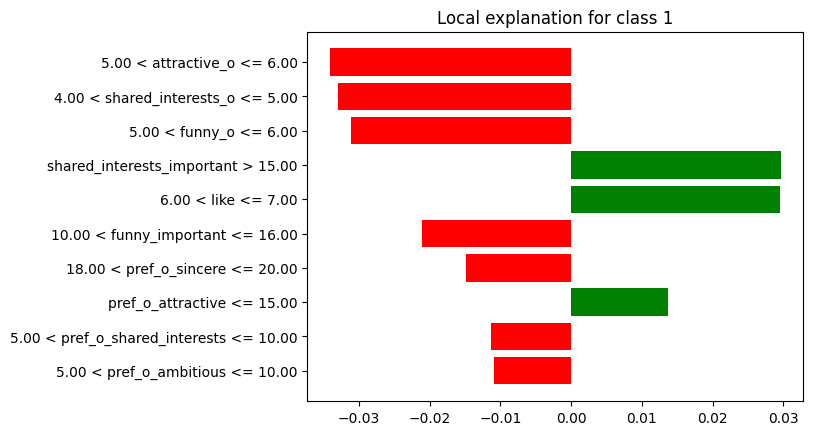

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate #cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Choose your test size to split between training and testing sets:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

rf = RandomForestClassifier(random_state=12)
model_rf = rf.fit(X, y)

import dalex as dx

np.random.seed(42)

explainer = dx.Explainer(model_rf, X, y, verbose=False)
# observation = X_test.loc[[601]]
observation = X_test.iloc[:1]
explanation = explainer.predict_surrogate(observation)

# # # explanation.result
explanation.plot(), model_rf.predict_proba(observation)

### Scaling with StandardScaler (same result)

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(None, array([[0.84, 0.16]]))

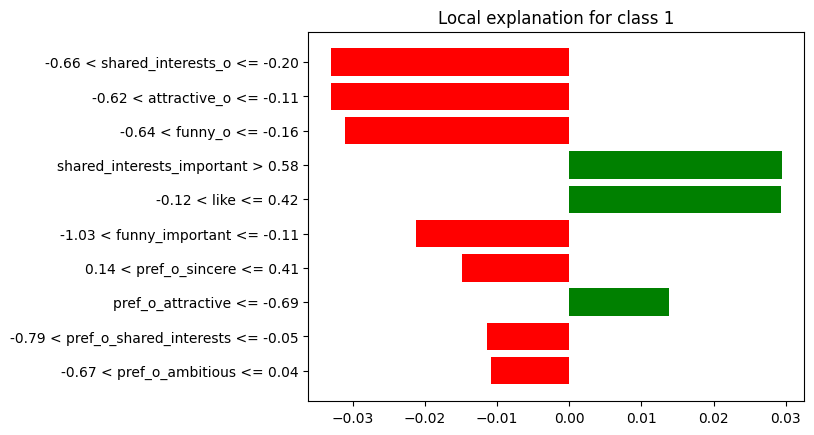

In [197]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Choose your test size to split between training and testing sets:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

scaler = StandardScaler()
scaler.fit(X)

scaled_data = scaler.fit_transform(X)
X = pd.DataFrame(scaled_data, columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

rf = RandomForestClassifier(random_state=12)
model_rf = rf.fit(X, y)

import dalex as dx

np.random.seed(42)

explainer = dx.Explainer(model_rf, X, y, verbose=False)
observation = X_test.loc[[601]]
# observation = X_test.iloc[:1]
explanation = explainer.predict_surrogate(observation)

# # # explanation.result
explanation.plot(), model_rf.predict_proba(observation)

### Scaling with MinMaxScaler (same result)

C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(None, array([[0.84, 0.16]]))

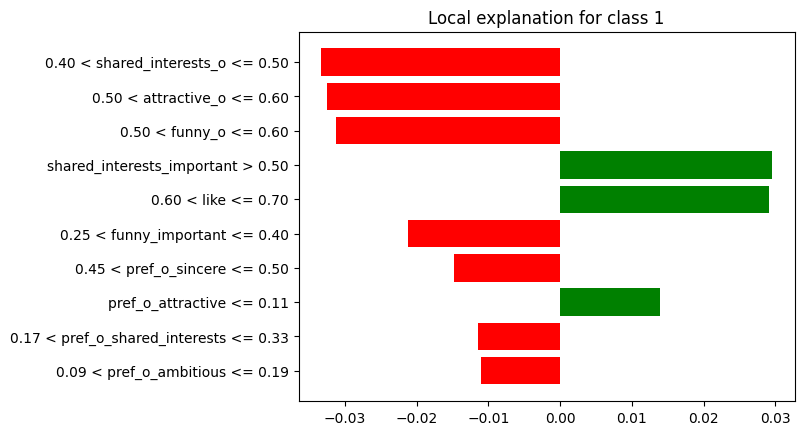

In [198]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Choose your test size to split between training and testing sets:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X)

scaled_data = scaler.fit_transform(X)
X = pd.DataFrame(scaled_data, columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

rf = RandomForestClassifier(random_state=12)
model_rf = rf.fit(X, y)

import dalex as dx

np.random.seed(42)

explainer = dx.Explainer(model_rf, X, y, verbose=False)
observation = X_test.loc[[601]]
# observation = X_test.iloc[:1]
explanation = explainer.predict_surrogate(observation)

# # # explanation.result
explanation.plot(), model_rf.predict_proba(observation)

In [505]:
!jupyter nbconvert --to=html --template=classic HW3_lime.ipynb

[NbConvertApp] Converting notebook HW3_lime.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 4177135 bytes to HW3_lime.html
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [508]:
!cd

C:\Projects\MIMUW\xai\fork\eXplainableMachineLearning-2024\Homeworks\HW3


In [506]:
!ls

 Volume in drive C is OS
 Volume Serial Number is 1491-1811

 Directory of C:\Projects\MIMUW\xai\fork\eXplainableMachineLearning-2024\Homeworks\HW3

27.10.2023  18:13    <DIR>          .
27.10.2023  18:13    <DIR>          ..
26.10.2023  22:09    <DIR>          .ipynb_checkpoints
27.10.2023  00:17         1˙327˙169 all_effects.png
20.10.2023  00:55           620˙041 HW2.ipynb
24.10.2023  13:58         3˙147˙871 hw3.html
24.10.2023  13:58    <DIR>          hw3_files
27.10.2023  18:13         4˙191˙936 HW3_lime.html
27.10.2023  18:13         3˙857˙191 HW3_lime.ipynb
26.10.2023  20:05         4˙027˙280 Materials towards Homework 3 LIME with XGBoost & SVM.ipynb
13.10.2023  00:02             2˙815 README.md
26.10.2023  17:53            95˙943 SpeedDating.csv
               8 File(s)     17˙270˙246 bytes
               4 Dir(s)  214˙723˙137˙536 bytes free
